In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [6]:
sys.path.append('/home/local/WIN/msang2/mankun/dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
from Simulations.odeSolver.doubleS import rxnNetwork, labels
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [7]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

# c) residence time v.s. KPP & CP0, strong KPN

In [17]:
def criticalRate_approx(parm):
    kbPS = parm['kbPS'].to_numpy()
    kbPN = parm['kbPN'].to_numpy()
    chiN = parm['KPN'].to_numpy()*parm['CN0'].to_numpy()
    chiS = parm['KPS'].to_numpy()*parm['CS0'].to_numpy()
    gamma = parm['gamma'].to_numpy()
    return gamma*(kbPS*chiS + kbPN*chiN)

In [18]:
GenParm = lambda nDenseKPP, kbP: GenParameters(
    numTargets=2, KPN=[20], KPS=lambda KPN: 20000, area3Dto1D=[10], 
#     kaPN=1, kaPS=2, 
    NP0=[0.1], KPP=np.logspace(0,9,10+9*nDenseKPP), kbPP_fixed=kbP
)
parm_file = pd.concat((GenParm(10, 1), GenParm(10, 0.1), GenParm(10, 10)))
parm_num = pd.concat((GenParm(0, 1), GenParm(0, 0.1), GenParm(0, 10)))

In [11]:
def calc_resT_irr_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    C0 = 0.6022
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    num_PS = 2*chiN + gam*chiN**2 + 2*chiS*(1+gam*chiN)**2
    num_PS2 = C0*KPS*chiS*(1+gam*chiN)**2
    return (num_PS+num_PS2)/2/chiN/(1+aS_to_aN) / koffN

def calc_resT_monomer_2state(parm):
    gam = parm['gamma']
    konS = parm['kaPS']
    KPS = parm['KPS']
    CS = parm['CS0']
    konN = parm['kaPN']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    chiS = KPS*CS
    aS_to_aN = konS*CS / (konN*CN)
    return (chiN+chiS*(1+gam*chiN))/chiN/(1+aS_to_aN) / koffN

def calc_tauA_irr(parm):
    gam = parm['gamma']
    koffN = parm['kbPN']
    KPN = parm['KPN']
    CN = parm['CN0']
    # combined parms
    chiN = KPN*CN
    return (1+gam*chiN/2)/koffN

resT_2s = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    resT_2s[iloc] = ana.ana_resTime_balance(parm, numClusterS=2)
resT_2s_m = calc_resT_monomer_2state(parm_file)
resT_A_irr = calc_tauA_irr(parm_file)

In [12]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

resT_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    resT_num[iloc] = num.calc_resT_modelC(parm, equi)
resT_num_m = calc_resT_monomer_2state(parm_num)

2025-02-03 15:59:08.496526
Number of cores used:  30/36
Finished parallel processing.


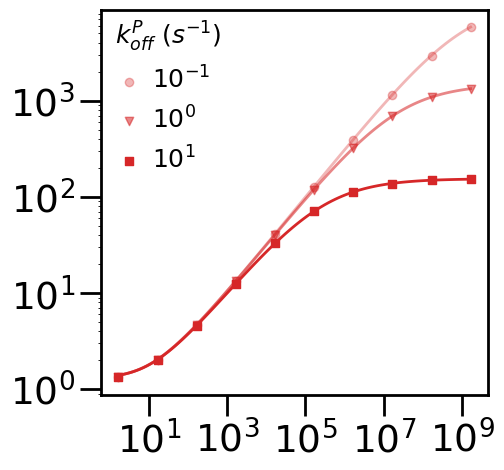

In [13]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.01,0.55], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$k_{off}^P\ (s^{-1})$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
kbP_color = 'tab:red'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
kbPList = np.unique(parm_file['kbPP'])
for i, kbP in enumerate(kbPList):
    selected = ((parm_file['kbPP']==kbP))
    selected_num = ((parm_num['kbPP']==kbP))
    ax.plot(
        (parm_file['KPP'])[selected],
        (resT_2s*parm_file['kbPS'])[selected],
        lw=2, color=kbP_color, alpha=alphas[i],
    )
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPP'])[selected_num],
        (resT_num*parm_num['kbPS'])[selected_num],
        label='$10^{%.0f}$'%np.log10(kbP),
        marker=markers[i], color=kbP_color, alpha=alphas[i],
    )

ax.loglog()
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
plt.show()

# b) occupancy v.s. KPP, KPN

In [14]:
GenParm = lambda nDenseKPP, areaList, kpnList: GenParameters(
    numTargets=2, KPN=kpnList, area3Dto1D=areaList, KPS=lambda KPN: 1e4,
    NP0=[2], KPP=np.logspace(0,9,10+9*nDenseKPP), 
)

parm_file = GenParm(10, [1,10,100], [20])
parm_num = GenParm(0, [1,10,100], [20])

In [24]:
pBound = np.zeros(parm_file.shape[0])
sOcc = np.zeros(parm_file.shape[0])
for iloc in range(parm_file.shape[0]):
    parm = parm_file.iloc[iloc]
    pBound[iloc] = ana.ana_bound_ratio(parm, numClusterS=2)
    sOcc[iloc] = ana.ana_occupancy(parm, numClusterS=2)

In [25]:
equi_num = numericSolver(parm_df=parm_num, labels=labels, model=rxnNetwork)

2024-11-14 15:01:04.336282
Number of cores used:  30/36
Finished parallel processing.


In [26]:
pBound_num = np.zeros(parm_num.shape[0])
sOcc_num = np.zeros(parm_num.shape[0])
for iloc in range(parm_num.shape[0]):
    parm = parm_num.iloc[iloc]
    equi = equi_num.iloc[iloc]
    pBound_num[iloc] = num.calc_BoundRatio_modelC(parm, equi)
    sOcc_num[iloc] = num.calc_occS_modelC(parm, equi)

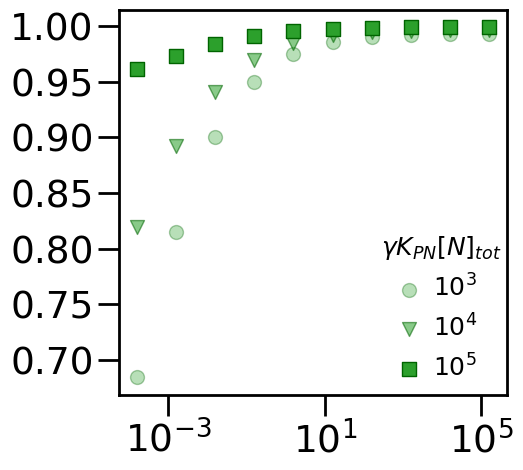

In [27]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, colors, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.65,0.01], lgdFontSize=18, lgdHandleL=0.3, 
    lgdTitle='$\gamma K_{PN}[N]_{tot}$', lgdTtlFontSize=18,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
alphas = [3/9, 5/9, 1]
markers = ['o','v','s']
gam_color = 'tab:green'
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
linsStyles = ['-', '--']

gamList = np.unique(parm_file['gamma'])
for i, gam in enumerate(gamList):
    selected = ((parm_file['gamma']==gam))
    selected_num = ((parm_num['gamma']==gam))
    # numerical solution (true)
    ax.scatter(
        (parm_num['KPP']*parm_num['CP0'])[selected_num],
        (sOcc_num/(parm_num['CP0']/parm_num['CS0']))[selected_num],
        zorder=3, s=100, color = gam_color, edgecolor='darkgreen', 
        alpha=alphas[i], marker=markers[i],
        label='$10^{%.0f}$'%(np.log10(gam*np.unique(parm_num['KPN']))),
    )

ax.semilogx()
plt.legend(**legend)
plt.xticks([1e-3, 1e1, 1e5], **tickfont)
plt.yticks(**tickfont)
# plt.xticks([1e-6, 1e-3, 1e0, 1e3],['$10^{-6}$', '$10^{-3}$', '$10^{0}$', '$10^{3}$'],**tickfont)
# plt.yticks([0.65, 0.82, 1],['0.65', '0.82', '1.00'],**tickfont)
plt.show()

# a) protein bound ratio

In [37]:
GenParms = lambda KPNList, KPP: GenParameters(
    numTargets=2, KPN=KPNList, KPS=lambda KPN: 1e4, 
    NP0=[0.02], KPP=[KPP], area3Dto1D=[10, 1000],
)
KPP_rev = 3e2

In [38]:
parm_ana = GenParms(np.logspace(1, 3, 5+2*40)*2.0, KPP_rev)

parm_num_irr = GenParms(np.logspace(1, 3, 5+2*0)*2.0, np.inf)
parm_num_rev = GenParms(np.logspace(1, 3, 5+2*0)*2.0, KPP_rev)
parm_num_m = GenParms(np.logspace(1, 3, 5+2*0)*2.0, 0)

In [40]:
def pBound_irr(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    KPS = parms['KPS']
    C0 = 0.6022
    proBound = 2*chiN + gam*chiN**2 + (2*chiS + C0*KPS*chiS)*(1+gam*chiN)**2
    return proBound / (1 + proBound)

def pBound_m(parms):
    gam = parms['gamma']
    chiN = parms['KPN']*parms['CN0']
    chiS = parms['KPS']*parms['CS0']
    proBound = chiN + chiS*(1+gam*chiN)
    return proBound / (1 + proBound)

pBound_irr = pBound_irr(parm_ana)
pBound_m = pBound_m(parm_ana)
pBound_rev = np.zeros(parm_ana.shape[0])
for iloc in range(parm_ana.shape[0]):
    pBound_rev[iloc] = ana.ana_bound_ratio(parm_ana.iloc[iloc], numClusterS=2)

In [41]:
equi_m = numericSolver(parm_df=parm_num_m, labels=labels, model=rxnNetwork)
equi_irr = numericSolver(parm_df=parm_num_irr, labels=labels, model=rxnNetwork)
equi_rev = numericSolver(parm_df=parm_num_rev, labels=labels, model=rxnNetwork)

pBound_num_m = np.zeros(parm_num_m.shape[0])
pBound_num_irr = np.zeros(parm_num_m.shape[0])
pBound_num_rev = np.zeros(parm_num_m.shape[0])
for iloc in range(parm_num_m.shape[0]):
    pBound_num_m[iloc] = num.calc_BoundRatio_modelC(parm_num_m.iloc[iloc], equi_m.iloc[iloc])
    pBound_num_irr[iloc] = num.calc_BoundRatio_modelC(parm_num_irr.iloc[iloc], equi_irr.iloc[iloc])
    pBound_num_rev[iloc] = num.calc_BoundRatio_modelC(parm_num_rev.iloc[iloc], equi_rev.iloc[iloc])

2024-11-14 16:07:41.425733
Number of cores used:  10/36
Finished parallel processing.
2024-11-14 16:07:41.750216
Number of cores used:  10/36
Finished parallel processing.
2024-11-14 16:07:42.594188
Number of cores used:  10/36
Finished parallel processing.


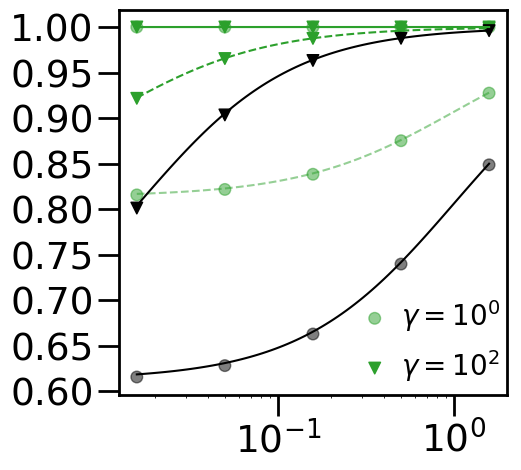

In [42]:
# >>>>>>>>>>>>>>>>>>>>>>>> Initialize Plotting >>>>>>>>>>>>>>>>>>>>>>>>
ax, _, lineStyles, legend, labelfont, tickfont, C0 = plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.62,0.00], lgdFontSize=20, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=20,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
)
color_gamma = 'tab:green'
alphas = [0.5, 1]
markers = ['o','v']
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
gamList = np.unique(parm_ana['gamma'])
for j, gam in enumerate(gamList):
    selected = ((parm_ana['gamma']==gam))
    # analytics
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_irr[selected], ls='-',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_rev[selected], ls='--',
        color = color_gamma, alpha=alphas[j],
    )
    ax.plot(
        (parm_ana['KPN']*parm_ana['CN0'])[selected],
        pBound_m[selected],
        color='black',
    )
    # numerics
    selected_num = ((parm_num_irr['gamma']==gam))
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_irr[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
        label='$\\gamma=10^{%.0f}$'%np.log10(gam),
    )
    ax.scatter(
        (parm_num_irr['KPN']*parm_num_irr['CN0'])[selected_num],
        pBound_num_rev[selected_num], s=70,
        ls='', marker=markers[j],
        color=color_gamma, alpha=alphas[j],
    )
    ax.scatter(
        (parm_num_m['KPN']*parm_num_m['CN0'])[selected_num],
        pBound_num_m[selected_num],  s=70,
        marker=markers[j], alpha=alphas[j],
        ls='', color='black',
    )
    
ax.semilogx()
# ax.set_aspect(aspect=1, adjustable='box')
plt.legend(**legend)
plt.xticks(**tickfont)
plt.yticks(**tickfont)
# plt.grid(axis='x')
plt.savefig('pBound_vs_chiN_gamma.png', transparent=True)
# plt.show()